# 0. Libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

# from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
# from sklearn.preprocessing import LabelEncoder

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

# import tensorflow as tf

# import warnings
# warnings.filterwarnings(action='ignore')

SEED = 42
np.random.seed(SEED)
# tf.random.set_seed(SEED)

In [2]:
import os
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 여러개 사용시 '0,1,2' 식으로 하나의 문자열에 입력
gpus = tf.config.experimental.list_physical_devices('GPU') # 호스트 러나임에 표시되는 GPU 장치 목록 반환

if gpus: # 반환된 GPU 장치 목록이 있다면
    try: # 해당 장치에 대한 메모리 증가 활성화 여부 설정
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e: # try문 실패시에 에러문구 출력
        print(e)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12093185985018032516
xla_global_id: -1
]
[]


# 1. Dataset

dataset(3)
- dataTO
- dataA
  - t503
  - t103

In [3]:
path = "./Dataset/"

# original dataset
original = pd.read_csv(path+"train.csv")
# dataA = pd.read_csv(path+"train_A.csv")  
dataT = pd.read_csv(path+"train_T.csv")  
dataO = pd.read_csv(path+"train_O.csv")  
dataTO = pd.concat([dataT, dataO]).reset_index(drop=True)

# print("data A: ", dataA.shape)
print("data TO: ", dataTO.shape)

data TO:  (838, 1136)


In [4]:
datasetA = []

t50304 = dataA[dataA['LINE'] =='T050304']
t50307 = dataA[dataA['LINE'] =='T050307']
t503 = pd.concat([t50304, t50307]).reset_index(drop=True)
datasetA.append(t503)

t10305 = dataA[dataA['LINE'] =='T010305']
t10306 = dataA[dataA['LINE'] =='T010306']
t103 = pd.concat([t10305, t10306]).reset_index(drop=True)
datasetA.append(t103)

print("data A - t503: ", datasetA[0].shape)
print("data A - t103: ", datasetA[1].shape)

data A - t503:  (152, 2124)
data A - t103:  (142, 2124)


In [12]:
dataset = [dataTO, t503, t103]

for i, data in enumerate(dataset):
    print(str(i), "-> shape: ", data.shape)

0 -> shape:  (838, 1136)
1 -> shape:  (152, 2124)
2 -> shape:  (142, 2124)


# 2. Preprocessing

1. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1) 
2. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제 
3. 결측치 처리 (KNN Imputetor, fillna(0))
4. 정규화 (Robust, MinMax, Standard)
5. 카테고리 변수 수치화 (LINE, PRODUCT_CODE) LabelEncoder

In [16]:
# Default Preprocessing Step
processed_dataset = []

rs = RobustScaler()
ss = StandardScaler()
le = LabelEncoder() 
le.fit(original['LINE'])
print(le.classes_)

for data in dataset:
    # 1. Handling missing values 
    data = data.copy().fillna(0)

    # 2. 같은 값으로만 채워진 column 삭제 
    value_counts = data.iloc[:,4:].apply(lambda x: x.nunique(dropna=False))
    unique_columns = value_counts[value_counts >= 2].index
    duplicated_columns = value_counts[value_counts <= 1].index
    data = data.drop(duplicated_columns, axis=1)

    # 3. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제
    df = data.iloc[:,4:].T.drop_duplicates(keep='first').T
    data = pd.concat([data.iloc[:,:4], df], axis=1)

    # 4. Regularization -> Robust Scaler 
    data.iloc[:, 4:] = rs.fit_transform(data.iloc[:, 4:])

    # 5. Label Encoding 
    data['LINE'] = le.transform(data['LINE'])
    data['PRODUCT_CODE'] = data['PRODUCT_CODE'].replace({'T_31': 0, 'O_31':1, 'A_31': 2})    

    processed_dataset.append(data)

['T010305' 'T010306' 'T050304' 'T050307' 'T100304' 'T100306']


In [17]:
# Optional Preprocessing Step - 6. Multicollinearity 
from collinearity import SelectNonCollinear

OPTION = [1, 2]

for i, data in enumerate(processed_dataset):
    if i not in OPTION: continue
        
    nonX_data = data.iloc[:, :4]
    X_data = data.iloc[:, 4:]
    
    selector = SelectNonCollinear(0.9)
    selector.fit(X_data.values)
    mask = selector.get_support() # True or False

    selected_df = pd.DataFrame(X_data.loc[:,mask])
    data = pd.concat([nonX_data, selected_df], axis=1)
    processed_dataset[i] =  data

pass


In [18]:
for i, data in enumerate(processed_dataset):
    print(str(i), "-> shape: ", data.shape)

0 -> shape:  (838, 682)
1 -> shape:  (152, 417)
2 -> shape:  (142, 398)


# 3. Data Split

A data 
- 294 (0: 130, 1: 164)

t103
- 0: 79
- 1: (24+39) = 63

t503 
- 0: 51
- 1: (55+46) = 101

Test Data (147개) 
- 0: 65개 (t103/t503/39/26)
- 1: 82개 (t103/t503/31/51)

Train Data (147개)
- 0: 65개 (t103/t503/40/25)
- 1: 82개 (t103/t503/32/50)

Train Normal Data (130개)
- 0: 130개 (t103/t503/79/51)

In [4]:
input_dataset = [dataTO]
# input_dataset = processed_dataset.copy()

test_dataset = []
train_dataset = []
normal_dataset = []
abnormal_dataset = []

for i, data in enumerate(input_dataset): 
    print(str(i), '-> Data:', data.shape)
    
    # Divide processed_data to abnormal and normal 
    normal_data = data[data['Y_Class']==1]
    normal_data['Y_Class'] = normal_data['Y_Class'].replace({1: 0}) # normal -> 0

    undershoot = data[data['Y_Class']==0]
    overshoot = data[data['Y_Class']==2]
    abnormal_data = pd.concat([undershoot, overshoot])
    abnormal_data['Y_Class'] = abnormal_data['Y_Class'].replace({2: 1, 0: 1}) # abnormal -> 1 

    normal_dataset.append(normal_data)
    abnormal_dataset.append(abnormal_data)
    print(str(i), '-> Normal Data:', normal_data.shape, ', Abnormal Data:', abnormal_data.shape)

    # Create test data (normal 65, abnormal 82 = 147)
    if i==0: LENGTH0, LENGHT1 = 100, 100        
    elif i==1: LENGTH0, LENGHT1 = len(normal_data)//2 + 1, len(abnormal_data)//2
    elif i==2: LENGTH0, LENGHT1 = len(normal_data)//2, len(abnormal_data)//2 + 1
    test_normal = normal_data.sample(n = LENGTH0, random_state = SEED)
    test_abnormal = abnormal_data.sample(n = LENGHT1, random_state = SEED) 
    test_data = pd.concat([test_normal, test_abnormal])
    
    test_dataset.append(test_data)
    print(str(i), '-> Test Data:', test_data.shape)

    # Create train data based on normal data (638)
    train_normal = normal_data.drop(test_normal.index)
    train_abnormal = abnormal_data.drop(test_abnormal.index)
    train_data = pd.concat([train_normal, train_abnormal])
    
    train_dataset.append(train_data)
    print(str(i), '-> Train Data:', train_data.shape, '\n')

0 -> Data: (838, 1136)
0 -> Normal Data: (636, 1136) , Abnormal Data: (202, 1136)
0 -> Test Data: (200, 1136)
0 -> Train Data: (638, 1136) 



C:\Users\user\AppData\Local\Temp\ipykernel_19688\288570277.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_data['Y_Class'] = normal_data['Y_Class'].replace({1: 0}) # normal -> 0


In [ ]:
train_data.to_csv('train_T.csv')

# 4. Regression for  Y_Quality 

In [30]:
best_models = []

In [110]:
from pycaret.regression import *
from time import time

# Setup Environment  

cat_cols = ['LINE', 'PRODUCT_CODE', 'Y_Class']
FOLD = 5
NUMBER = 1

reg = setup(data = train_dataset[NUMBER], 
            train_size = 0.8,
            test_data = test_dataset[NUMBER],
            target = 'Y_Quality',
            ignore_features = cat_cols,
            #preprocess = True,  # default True
            # feature_selection = True,
            #n_features_to_select = 0.2, # default 0.2
            fold=FOLD, # defualt 10 
            fold_shuffle=True,
            use_gpu = True,
            session_id = SEED)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,42
1,Target,Y_Quality
2,Target type,Regression
3,Original data shape,"(142, 398)"
4,Transformed data shape,"(142, 395)"
5,Transformed train set shape,"(72, 395)"
6,Transformed test set shape,"(70, 395)"
7,Ignore features,3
8,Numeric features,394
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [111]:
# EG, Cat, GBR, LGBM, XGB
top5 = compare_models(sort='r2', n_select=5, fold=FOLD, exclude=['lar', 'par', 'huber'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0054,0.0001,0.0071,0.3926,0.0046,0.0101,11.4160
et,Extra Trees Regressor,0.0053,0.0001,0.0071,0.3684,0.0046,0.0099,0.1740
gbr,Gradient Boosting Regressor,0.0055,0.0001,0.0072,0.3161,0.0047,0.0103,0.4060
ada,AdaBoost Regressor,0.0055,0.0001,0.0074,0.3038,0.0048,0.0104,0.1620
rf,Random Forest Regressor,0.0057,0.0001,0.0074,0.2948,0.0048,0.0107,0.2280
br,Bayesian Ridge,0.0067,0.0001,0.0083,0.0856,0.0054,0.0126,0.0340
xgboost,Extreme Gradient Boosting,0.0063,0.0001,0.0082,0.0813,0.0054,0.0118,0.3680
ridge,Ridge Regression,0.0067,0.0001,0.0084,0.0756,0.0055,0.0126,0.0280
lr,Linear Regression,0.0067,0.0001,0.0084,0.0697,0.0055,0.0127,0.0320
knn,K Neighbors Regressor,0.0069,0.0001,0.0092,-0.0420,0.0060,0.0130,0.0320


In [112]:
total_models = []
tuned_models = []

for i, model in enumerate(top5):
    cell_start_time = time() 
    print(top5[i])
    model = create_model(model, fold=FOLD)
    # tuned_model = tune_model(model, fold=5, optimize='r2', choose_better=True)
    total_models.append(model)
    # tuned_models.append(tuned_model)
    cell_end_time = time()
    print("CELL RUN TIME: ", cell_end_time - cell_start_time)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0041,0.0000,0.0051,0.3375,0.0033,0.0077
1,0.0049,0.0000,0.0068,0.4307,0.0044,0.0091
2,0.0042,0.0000,0.0055,0.5178,0.0036,0.0077
3,0.0077,0.0001,0.0096,0.2677,0.0062,0.0142
4,0.0061,0.0001,0.0083,0.4094,0.0055,0.0116
Mean,0.0054,0.0001,0.0071,0.3926,0.0046,0.0101
Std,0.0014,0.0000,0.0017,0.0849,0.0011,0.0025


CELL RUN TIME:  68.6245493888855
ExtraTreesRegressor(n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0037,0.0000,0.0054,0.2380,0.0036,0.0071
1,0.0044,0.0000,0.0063,0.5141,0.0041,0.0082
2,0.0056,0.0000,0.0069,0.2433,0.0045,0.0105
3,0.0069,0.0001,0.0086,0.4130,0.0056,0.0129
4,0.0057,0.0001,0.0081,0.4337,0.0054,0.0109
Mean,0.0053,0.0001,0.0071,0.3684,0.0046,0.0099
Std,0.0011,0.0000,0.0012,0.1097,0.0008,0.0020


CELL RUN TIME:  1.1823139190673828
GradientBoostingRegressor(random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0053,0.0000,0.0069,-0.2324,0.0045,0.0101
1,0.0047,0.0000,0.0063,0.5128,0.0041,0.0088
2,0.0038,0.0000,0.0048,0.6278,0.0031,0.0072
3,0.0074,0.0001,0.0095,0.2881,0.0062,0.0137
4,0.0060,0.0001,0.0085,0.3843,0.0056,0.0115
Mean,0.0055,0.0001,0.0072,0.3161,0.0047,0.0103
Std,0.0012,0.0000,0.0016,0.2974,0.0011,0.0022


CELL RUN TIME:  2.6087701320648193
AdaBoostRegressor(random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0049,0.0000,0.0063,-0.0223,0.0041,0.0092
1,0.0046,0.0000,0.0065,0.4904,0.0042,0.0085
2,0.0051,0.0000,0.0061,0.4057,0.0040,0.0095
3,0.0077,0.0001,0.0095,0.2766,0.0062,0.0143
4,0.0054,0.0001,0.0086,0.3686,0.0057,0.0103
Mean,0.0055,0.0001,0.0074,0.3038,0.0048,0.0104
Std,0.0011,0.0000,0.0014,0.1769,0.0009,0.0021


CELL RUN TIME:  1.1303648948669434
RandomForestRegressor(n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0054,0.0000,0.0066,-0.1386,0.0043,0.0103
1,0.0043,0.0000,0.0064,0.5019,0.0041,0.0079
2,0.0048,0.0000,0.0055,0.5108,0.0036,0.0089
3,0.0084,0.0001,0.0103,0.1550,0.0067,0.0155
4,0.0056,0.0001,0.0081,0.4451,0.0053,0.0108
Mean,0.0057,0.0001,0.0074,0.2948,0.0048,0.0107
Std,0.0014,0.0000,0.0017,0.2528,0.0011,0.0026


CELL RUN TIME:  1.5716843605041504


In [113]:
blender_top5 = blend_models(estimator_list=total_models)
# blender_tuned5 = blend_models(estimator_list=tuned_models)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0047,0.0000,0.0058,0.1331,0.0038,0.0089
1,0.0043,0.0000,0.0062,0.5250,0.0040,0.0080
2,0.0046,0.0000,0.0056,0.4985,0.0036,0.0086
3,0.0076,0.0001,0.0094,0.2969,0.0061,0.0141
4,0.0057,0.0001,0.0082,0.4239,0.0054,0.0109
Mean,0.0054,0.0001,0.0070,0.3755,0.0046,0.0101
Std,0.0012,0.0000,0.0015,0.1447,0.0010,0.0022


In [114]:
# for naive models 
total_predictions = []
for model in total_models: 
    pred = predict_model(model)
    total_predictions.append(pred)
print() 

# for tuned models 
# for model in tuned_models: 
#     prediction = predict_model(model)
# print() 

# for blended model 
pred_blend_top5 = predict_model(blender_top5)
print() 

# for blended model (tuned)
# pred_blend_tuned5 = predict_model(blender_tuned5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0042,0.0000,0.0055,0.6397,0.0036,0.0079


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0038,0.0000,0.0047,0.7315,0.0031,0.0071


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.0037,0.0000,0.0049,0.7157,0.0032,0.0069


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.0042,0.0000,0.0053,0.6594,0.0035,0.0079


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0042,0.0000,0.0055,0.6306,0.0036,0.0079


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0038,0.0000,0.0049,0.7085,0.0032,0.0072


In [115]:
best_model = total_models[1]
best_models.append(best_model)
best_model

ExtraTreesRegressor(n_jobs=-1, random_state=42)

In [116]:
test_data = test_dataset[NUMBER] # NUMBER

pred_yQuality = predict_model(best_model)
pred_yQuality = pd.DataFrame(pred_yQuality['prediction_label'])

test_data = pd.concat([test_data, pred_yQuality], axis=1)
test_dataset[NUMBER] = test_data
test_data

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0038,0.0000,0.0047,0.7315,0.0031,0.0071


,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_246,X_247,X_248,X_250,X_251,X_253,...,X_1670,X_1672,X_1674,X_1678,X_1679,X_1697,X_2044,X_2050,X_2051,prediction_label
52,0,0.528856,0,0,0.0,-0.25,-0.048518,0.0,0.150289,0.0,...,0.0,0.0,0.00,-0.583333,-0.500000,-0.400000,-0.318933,4.593536,-0.397661,0.528453
0,0,0.532754,0,0,0.0,-0.25,-0.048518,0.0,1.109827,-1.0,...,0.1,0.0,0.00,-0.250000,-0.500000,1.200000,0.814485,0.133203,0.252297,0.528805
37,0,0.530341,0,0,0.0,0.75,-0.048518,0.0,0.462428,-1.0,...,0.2,0.1,0.00,0.583333,0.444444,1.200000,1.327827,0.503428,0.568087,0.534974
53,0,0.530514,0,0,1.0,-0.50,-0.048518,0.0,0.485549,-1.0,...,0.0,0.0,0.00,1.333333,0.611111,0.266667,0.016518,-0.419197,-0.218881,0.528646
30,0,0.534376,0,0,1.0,-0.25,-0.048518,0.0,1.560694,-1.0,...,-0.1,0.0,-0.01,1.416667,1.222222,-0.066667,-0.607370,4.395690,-0.566416,0.532634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1,0.545925,1,0,1.0,0.75,1.784367,0.0,0.000000,0.0,...,0.0,0.0,0.00,1.333333,0.611111,-0.333333,-0.689962,0.001959,3.104428,0.539940
114,1,0.536616,1,0,1.0,0.25,1.654987,0.0,0.000000,0.0,...,-0.1,0.0,0.00,0.666667,-0.222222,-0.400000,-0.743329,-0.039177,3.069340,0.537573
28,1,0.555514,0,0,1.0,-0.75,-0.048518,0.0,1.317919,-1.0,...,0.0,0.0,0.00,1.333333,0.611111,0.533333,-0.689962,0.000000,3.102757,0.546611
24,1,0.536433,0,0,0.0,-0.50,-0.048518,0.0,1.930636,-1.0,...,0.0,0.0,0.00,0.166667,0.611111,-0.333333,-0.470140,4.503428,-0.474520,0.533570


# 5. Anomaly Detection for Y_Class based on Y_Quality 

In [125]:
# 130 X 4
normal_data = pd.concat([normal_dataset[0].iloc[:,:4], normal_dataset[1].iloc[:,:4]], axis=0).reset_index(drop=True)
print(normal_data.Y_Class.value_counts())
print(normal_data.shape)

0    130
Name: Y_Class, dtype: int64
(130, 4)


In [121]:
# 145 X 4 
cat_cols = ['prediction_label', 'LINE', 'PRODUCT_CODE', 'Y_Class']
test_data = pd.concat([test_dataset[0][cat_cols], test_dataset[1][cat_cols]])
print(test_data.Y_Class.value_counts())
print(test_data.shape)

1    81
0    64
Name: Y_Class, dtype: int64
(145, 4)


In [126]:
from pycaret.anomaly import *
from time import time

# Setup Environment  
anomaly = setup(data = pd.DataFrame(normal_data[['Y_Quality', 'LINE', 'PRODUCT_CODE']]),
                preprocess = False,
                use_gpu = True,
                session_id = SEED)

,Description,Value
0,Session id,42
1,Original data shape,"(130, 3)"
2,Transformed data shape,"(130, 3)"
3,Numeric features,3


In [127]:
# IForest, KNN, SVM, PCA, LoF, total five models  
iforest = create_model('iforest')
knn = create_model('knn')
svm = create_model('svm')
pca = create_model('pca')
lof = create_model('lof')

total_ads = [iforest, knn,  svm, pca, lof]

In [128]:
predictions_ads = []

for model in total_ads:
    pred = predict_model(model, data=test_data[['prediction_label', 'LINE', 'PRODUCT_CODE']])
    predictions_ads.append(pred)

predictions_ads[0].head()

,prediction_label,LINE,PRODUCT_CODE,Anomaly,Anomaly_Score
119,0.527300,3,0,0,-0.042524
110,0.525536,3,0,1,0.025468
131,0.532169,3,0,0,-0.004815
30,0.535068,2,0,1,0.026196
55,0.527212,2,0,0,-0.132580


In [130]:
def confusionMatrix(test_pred):
    test_y = test_data['Y_Class']
    con_mat = confusion_matrix(test_y, test_pred)
    sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    print("accuracy: ", accuracy_score(test_y, test_pred))
    print("recall: ", round(recall_score(test_y, test_pred),3))
    print("precision: ", round(precision_score(test_y, test_pred),3))
    print("f1-score: ", round(f1_score(test_y, test_pred),3))

accuracy:  0.6689655172413793
recall:  0.556
precision:  0.789
f1-score:  0.652


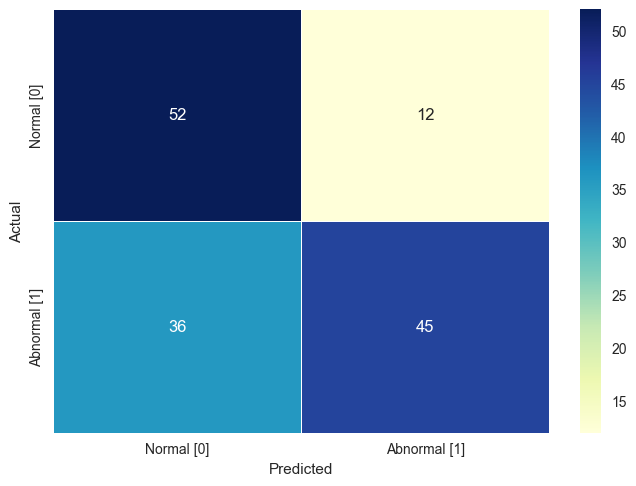

In [131]:
confusionMatrix(predictions_ads[0]['Anomaly'])

accuracy:  0.7448275862068966
recall:  0.617
precision:  0.893
f1-score:  0.73


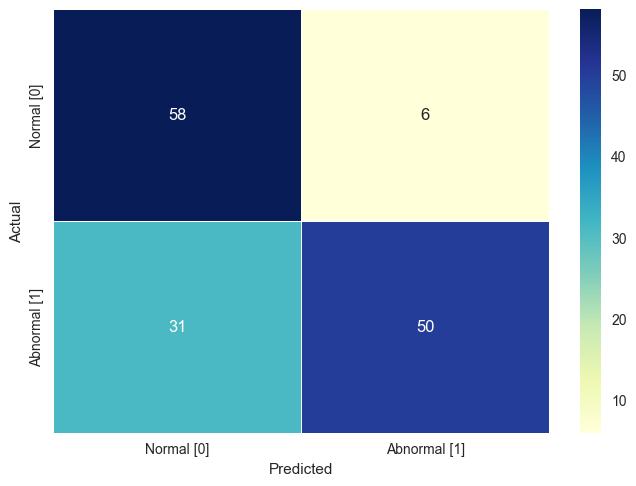

In [132]:
confusionMatrix(predictions_ads[1]['Anomaly'])

accuracy:  0.5862068965517241
recall:  0.309
precision:  0.862
f1-score:  0.455


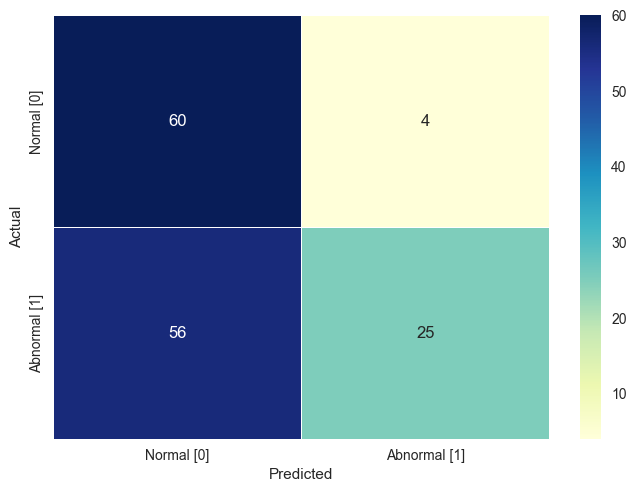

In [133]:
confusionMatrix(predictions_ads[2]['Anomaly'])

accuracy:  0.4413793103448276
recall:  0.0
precision:  0.0
f1-score:  0.0


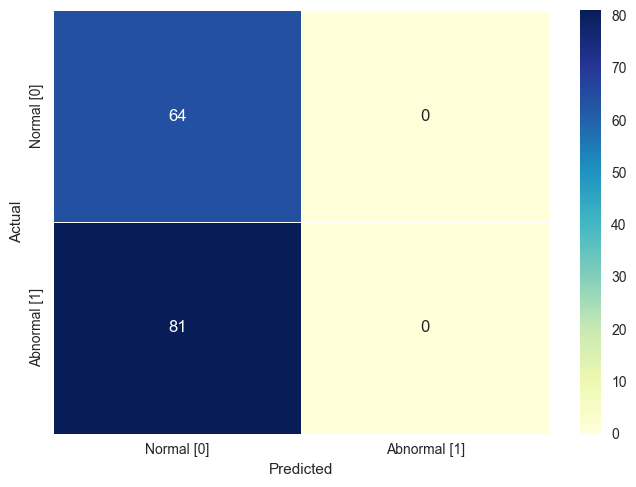

In [134]:
confusionMatrix(predictions_ads[3]['Anomaly'])

accuracy:  0.4413793103448276
recall:  0.0
precision:  0.0
f1-score:  0.0


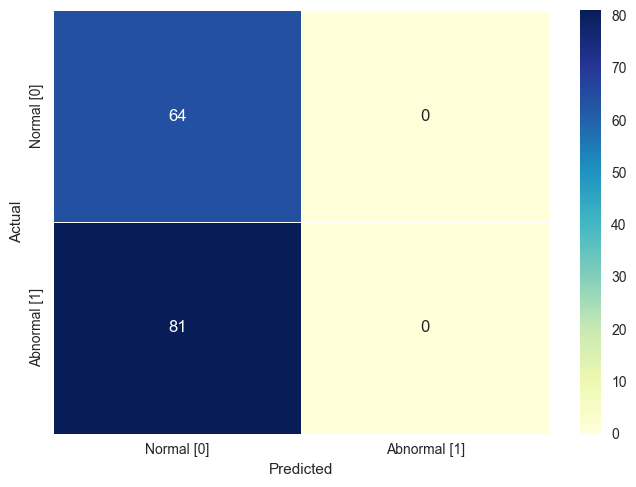

In [135]:
confusionMatrix(predictions_ads[4]['Anomaly'])

In [136]:
test_data['prediction'] = 1
normal = test_data[test_data['prediction_label']>=0.52]
normal = normal[normal['prediction_label']<=0.53]
normal['prediction'] =0
test_data = test_data.drop(normal.index)
test_data = pd.concat([test_data, normal])
test_data

,prediction_label,LINE,PRODUCT_CODE,Y_Class,prediction
131,0.532169,3,0,0,1
30,0.535068,2,0,0,1
43,0.530625,2,0,0,1
35,0.535023,2,0,0,1
24,0.532082,2,0,0,1
...,...,...,...,...,...
26,0.525984,0,0,1,0
103,0.520313,1,0,1,0
45,0.521428,0,0,1,0
31,0.528077,0,0,1,0


accuracy:  0.5609756097560976
recall:  0.5
precision:  0.648
f1-score:  0.565


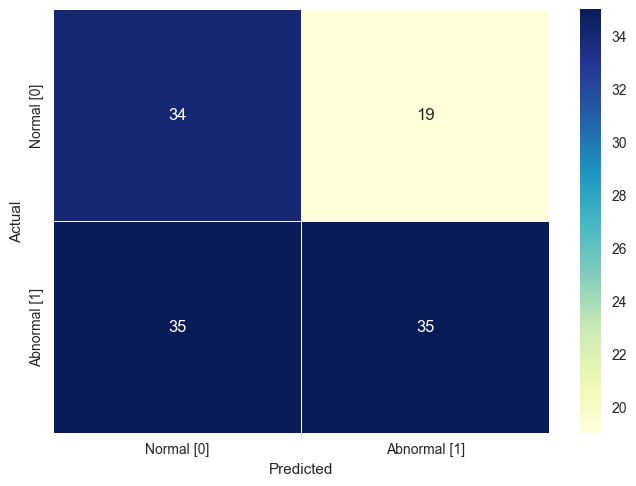

In [137]:
def confusionMatrix(test_pred):
    test_y = test_data['Y_Class']
    con_mat = confusion_matrix(test_y, test_pred)
    sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    print("accuracy: ", accuracy_score(test_y, test_pred))
    print("recall: ", round(recall_score(test_y, test_pred),3))
    print("precision: ", round(precision_score(test_y, test_pred),3))
    print("f1-score: ", round(f1_score(test_y, test_pred),3))
confusionMatrix(test_data['prediction'])

# 6. Plotting

In [ ]:
plot_model(best_model, plot='residuals')

In [ ]:
evaluate_model(best_model)

In [ ]:
interpret_model(total_models[CHECK], plot='summary')

In [ ]:
def graph(pred, true) :
    plt.figure(figsize=(16, 9))
    plt.plot(true, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

true_y = total_predictions[CHECK]['Y_Quality'].to_numpy()
pred_y = total_predictions[CHECK]['prediction_label'].to_numpy()
graph(pred_y, true_y)